In [24]:
from os import path

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from pyvo.dal import TAPService
from pyia import GaiaData

import gala.coordinates as gc
import scipy.stats
from scipy.stats import binned_statistic

In [25]:
plt.style.use('gd1_paper')

/home/ana/install/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))
/home/ana/install/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'interactive', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


In [3]:
t = Table.read('../data/gd1-all-ps1-red.fits')

In [4]:
# deredden
bands = ['g', 'r', 'i', 'z', 'y']
for band in bands:
    t[band] = t[band] - t['A_{}'.format(band)]

In [5]:
g = GaiaData(t)
c = coord.SkyCoord(ra=g.ra, dec=g.dec, pm_ra_cosdec=g.pmra, pm_dec=g.pmdec)

In [6]:
def gd1_dist(phi1):
    # 0, 10
    # -60, 7
    m = (10-7) / (60)
    return (m*phi1.wrap_at(180*u.deg).value + 10) * u.kpc

In [7]:
gd1_c = c.transform_to(gc.GD1)
gd1_c_noreflex = c.transform_to(gc.GD1)

gd1_c_dist = gc.GD1(phi1=gd1_c.phi1, phi2=gd1_c.phi2,
                    distance=gd1_dist(gd1_c.phi1),
                    pm_phi1_cosphi2=gd1_c.pm_phi1_cosphi2,
                    pm_phi2=gd1_c.pm_phi2,
                    radial_velocity=[0]*len(gd1_c)*u.km/u.s)

# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = gd1_c_dist.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
# gd1_c_nosunv = coord.Galactic(rep).transform_to(gc.GD1)
gd1_c = coord.Galactic(rep).transform_to(gc.GD1)

In [8]:
wangle = 180*u.deg

pm_mask = ((gd1_c.pm_phi1_cosphi2 < -5*u.mas/u.yr) & (gd1_c.pm_phi1_cosphi2 > -10*u.mas/u.yr) & 
           (gd1_c.pm_phi2 < 1*u.mas/u.yr) & (gd1_c.pm_phi2 > -2*u.mas/u.yr) & 
           (g.bp_rp < 1.5*u.mag) & (g.bp_rp > 0*u.mag))

/home/ana/install/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/ana/install/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [9]:
phi_mask_stream = ((np.abs(gd1_c.phi2)<1*u.deg) & (gd1_c.phi1.wrap_at(wangle)>-50*u.deg) & 
                   (gd1_c.phi1.wrap_at(wangle)<-10*u.deg))
phi_mask_off = ((gd1_c.phi2<-2*u.deg) & (gd1_c.phi2>-3*u.deg)) | ((gd1_c.phi2<3*u.deg) & (gd1_c.phi2>2*u.deg))

In [10]:
iso = Table.read('../data/mist_12.0_-1.35.cmd', format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<3)
iso = iso[phasecut]

In [11]:
# distance modulus
distance_app = 7.8*u.kpc
dm = 5*np.log10((distance_app.to(u.pc)).value)-5

# main sequence + rgb
i_gi = iso['PS_g']-iso['PS_i']
i_g = iso['PS_g']+dm

i_left = i_gi - 0.4*(i_g/28)**5
i_right = i_gi + 0.5*(i_g/28)**5

poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
ind = (poly[:,1]<21.3) & (poly[:,1]>17.8)
poly_main = poly[ind]

In [12]:
points = np.array([g.g - g.i, g.g]).T
path_main = mpl.path.Path(poly_main)
cmd_mask = path_main.contains_points(points)

pm1_min = -9*u.mas/u.yr
pm1_max = -4.5*u.mas/u.yr
pm2_min = -1.7*u.mas/u.yr
pm2_max = 1.*u.mas/u.yr
pm_mask = ((gd1_c.pm_phi1_cosphi2 < pm1_max) & (gd1_c.pm_phi1_cosphi2 > pm1_min) & 
           (gd1_c.pm_phi2 < pm2_max) & (gd1_c.pm_phi2 > pm2_min))

## Sample selection

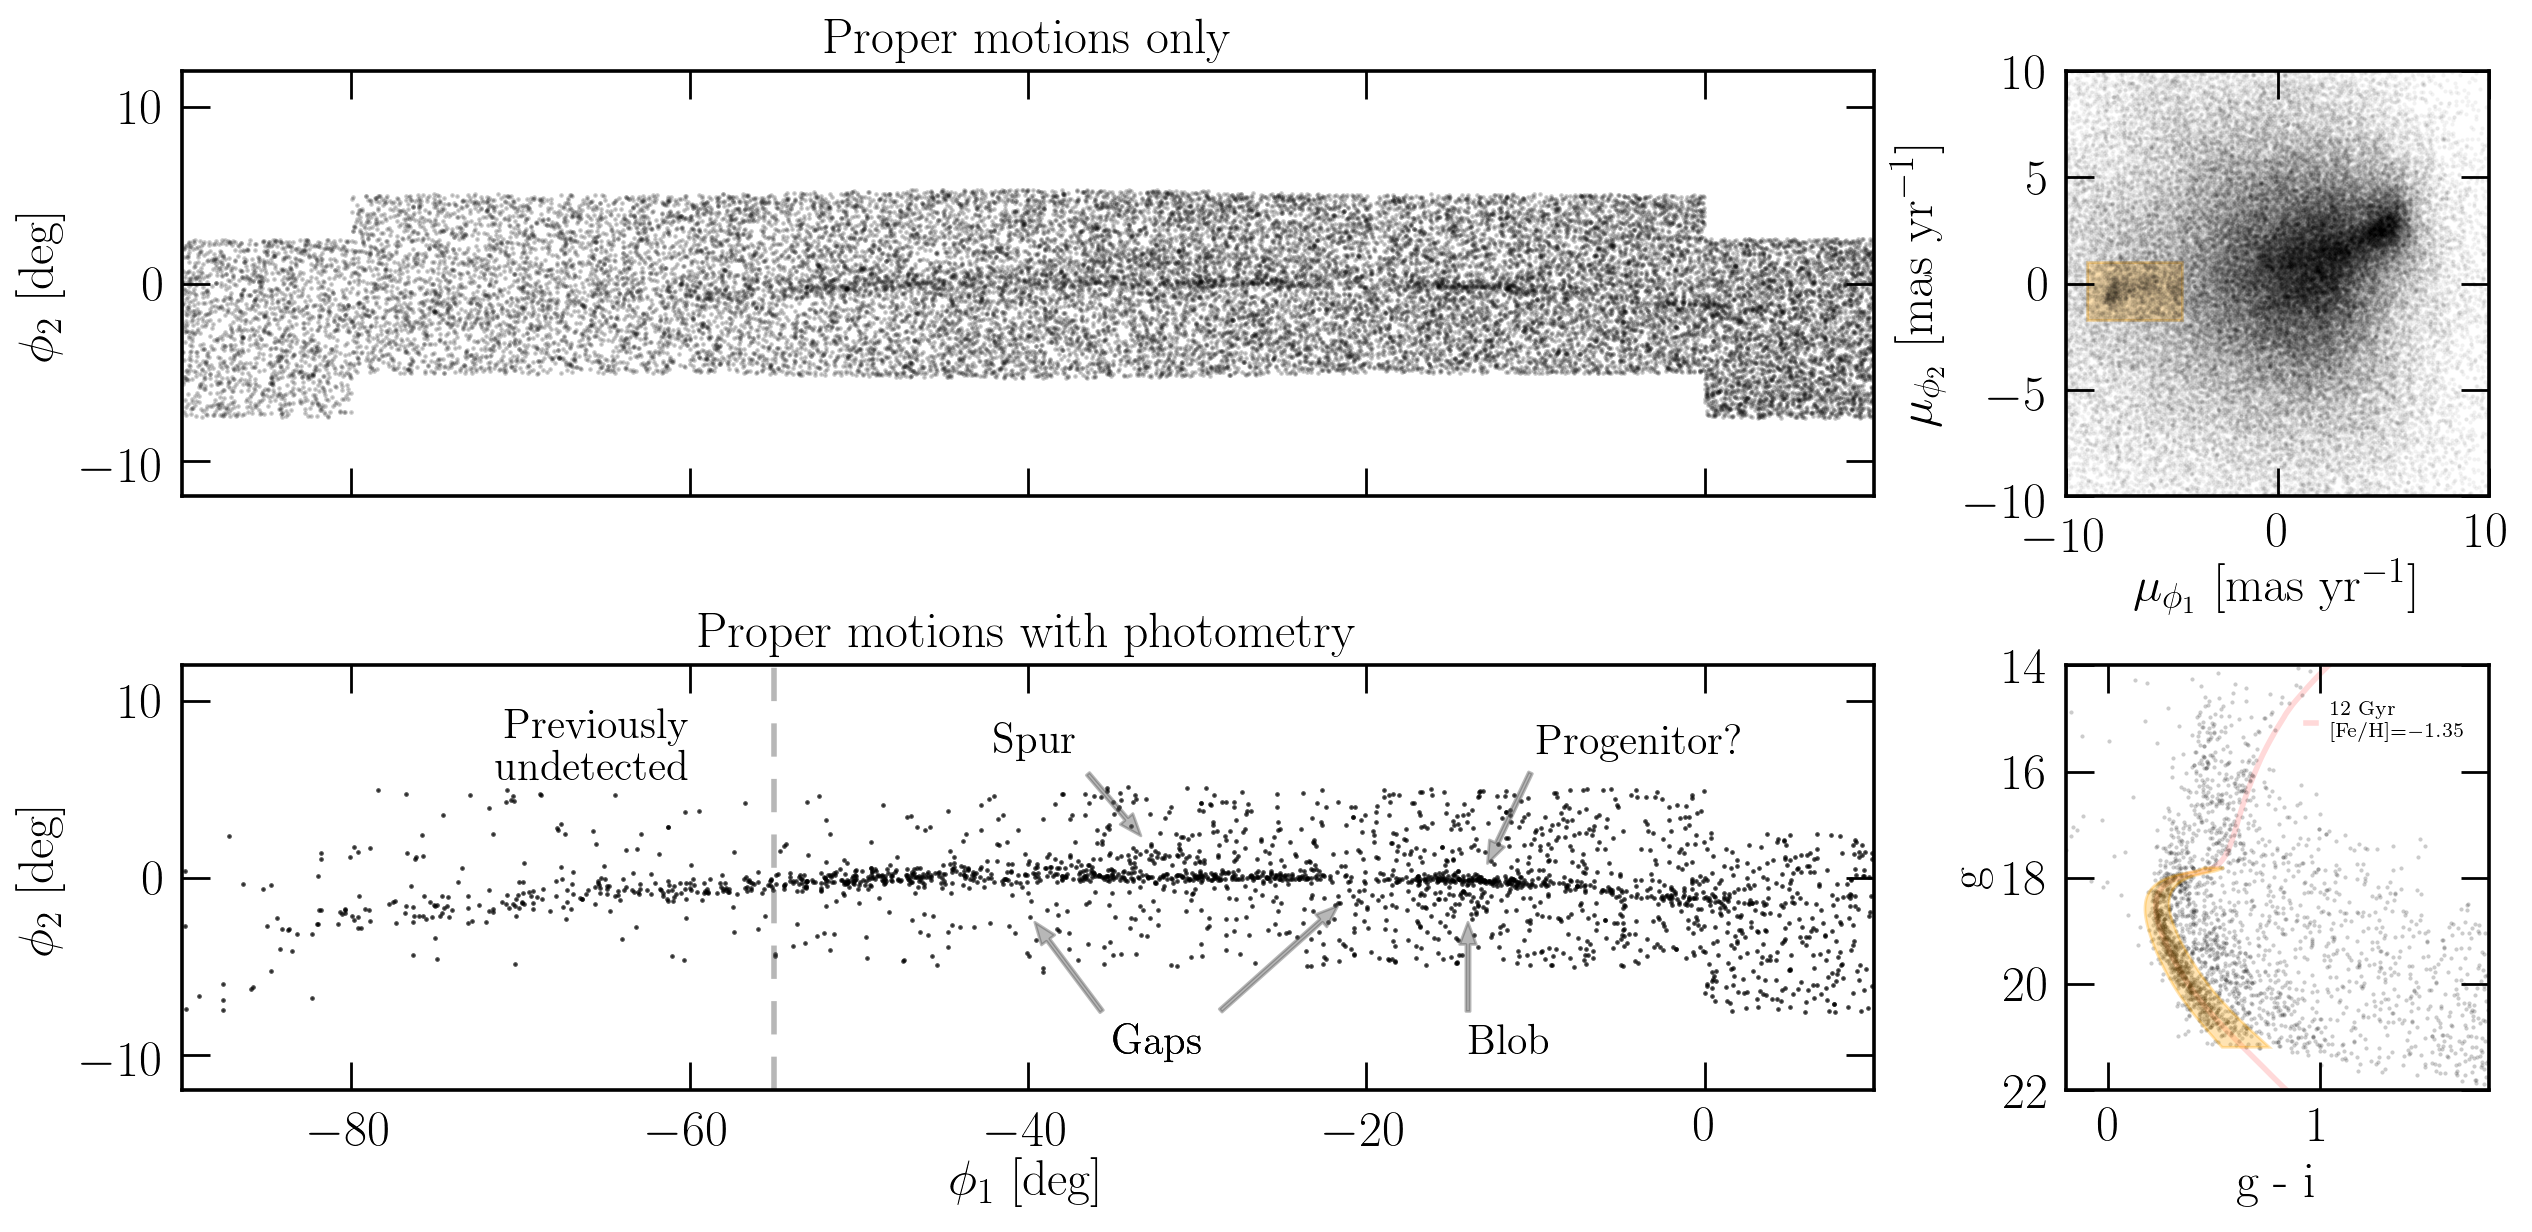

In [13]:
fig, ax = plt.subplots(2,2,figsize=(13,6.5), gridspec_kw = {'width_ratios':[4,1]})

plt.sca(ax[0][0])
plt.plot(gd1_c.phi1[pm_mask].wrap_at(wangle), gd1_c.phi2[pm_mask], 'ko', ms=0.7, alpha=0.2, rasterized=True)
# plt.gca().set_aspect('equal')

# plt.xlabel('$\phi_1$ (deg)')
plt.ylabel('$\phi_2$ [deg]')
plt.title('Proper motions only', fontsize='medium')

plt.setp(plt.gca().get_xticklabels(), visible=False)
plt.xlim(-90,10)
plt.ylim(-12,12)

plt.sca(ax[0][1])
plt.plot(gd1_c.pm_phi1_cosphi2[phi_mask_stream].to(u.mas/u.yr), 
         gd1_c.pm_phi2[phi_mask_stream].to(u.mas/u.yr), 
         'ko', ms=0.5, alpha=0.05, rasterized=True)

rect_xy = [pm1_min.to(u.mas/u.yr).value, pm2_min.to(u.mas/u.yr).value]
rect_w = pm1_max.to(u.mas/u.yr).value - pm1_min.to(u.mas/u.yr).value
rect_h = pm2_max.to(u.mas/u.yr).value - pm2_min.to(u.mas/u.yr).value
pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')

plt.sca(ax[1][0])
plt.plot(gd1_c.phi1[pm_mask & cmd_mask].wrap_at(wangle), gd1_c.phi2[pm_mask & cmd_mask],
         'ko', ms=0.7, alpha=0.7, rasterized=True)
# plt.gca().set_aspect('equal')

plt.annotate('Progenitor?', xy=(-13, 0.5), xytext=(-10, 7),
             arrowprops=dict(color='0.3', shrink=0.05, width=1.5, headwidth=6, headlength=8, alpha=0.4),
             fontsize='small')

plt.annotate('Blob', xy=(-14, -2), xytext=(-14, -10),
             arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
             fontsize='small')

plt.annotate('Spur', xy=(-33, 2), xytext=(-42, 7),
             arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
             fontsize='small')

plt.annotate('Gaps', xy=(-40, -2), xytext=(-35, -10),
             arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
             fontsize='small')

plt.annotate('Gaps', xy=(-21, -1), xytext=(-35, -10),
             arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
             fontsize='small')

plt.axvline(-55, ls='--', color='0.3', alpha=0.4, dashes=(6,4), lw=2)
plt.text(-60, 9.5, 'Previously\nundetected', fontsize='small', ha='right', va='top')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')
plt.title('Proper motions with photometry', fontsize='medium')

plt.xlim(-90,10)
plt.ylim(-12,12)

plt.sca(ax[1][1])
plt.plot(g.g[phi_mask_stream & pm_mask] - g.i[phi_mask_stream & pm_mask], g.g[phi_mask_stream & pm_mask], 
         'ko', ms=0.5, alpha=0.2, rasterized=True, label='')

plt.plot(i_gi, i_g, 'r-', lw=2, alpha=0.15, zorder=0, label='12 Gyr\n[Fe/H]=$-1.35$')
pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)

plt.legend(loc=1, frameon=False, fontsize=7, handlelength=0.5, bbox_to_anchor=(0.99,0.95))
plt.xlim(-0.2, 1.8)
plt.ylim(22, 14)
plt.xlabel('g - i')
plt.ylabel('g')

plt.tight_layout(h_pad=0.5, w_pad=0.5)
plt.savefig('../paper/gd1_sample.pdf')

In [14]:
np.sum(pm_mask&cmd_mask)

3485

## Features

In [15]:
titles = ['Stream', 'Stream', 'Spur', 'Off spur', 'Stream', 'Blob', 'Off blob', 'Off blob 2']

# phi1_min = np.array([-64, -37, -37, -37, -20, -20, -20, -20])*u.deg
# phi1_max = np.array([-56, -29, -29, -29, -12, -12, -12, -12])*u.deg
phi1_min = np.array([-64, -37, -37, -37, -19, -19, -19, -19])*u.deg
phi1_max = np.array([-56, -29, -29, -29, -11, -11, -11, -11])*u.deg
phi2_min = np.array([-1.7, -0.4, 0.5, -1.9, -0.6, -2, 0.3, 1.7])*u.deg
phi2_max = np.array([0.3, 0.5, 2, -0.4, 0.3, -0.6, 1.7, 3.1])*u.deg
Npos = np.size(phi1_min)

pos_masks = []
for i in range(Npos):
    pos_masks = pos_masks + [((gd1_c.phi1.wrap_at(wangle)<phi1_max[i]) & (gd1_c.phi1.wrap_at(wangle)>phi1_min[i]) &
            (gd1_c.phi2<phi2_max[i]) & (gd1_c.phi2>phi2_min[i]))]

pm_generous_mask = ((gd1_c.pm_phi1_cosphi2 < -4*u.mas/u.yr) & (gd1_c.pm_phi1_cosphi2 > -10*u.mas/u.yr) & 
           (gd1_c.pm_phi2 < 1*u.mas/u.yr) & (gd1_c.pm_phi2 > -2*u.mas/u.yr))

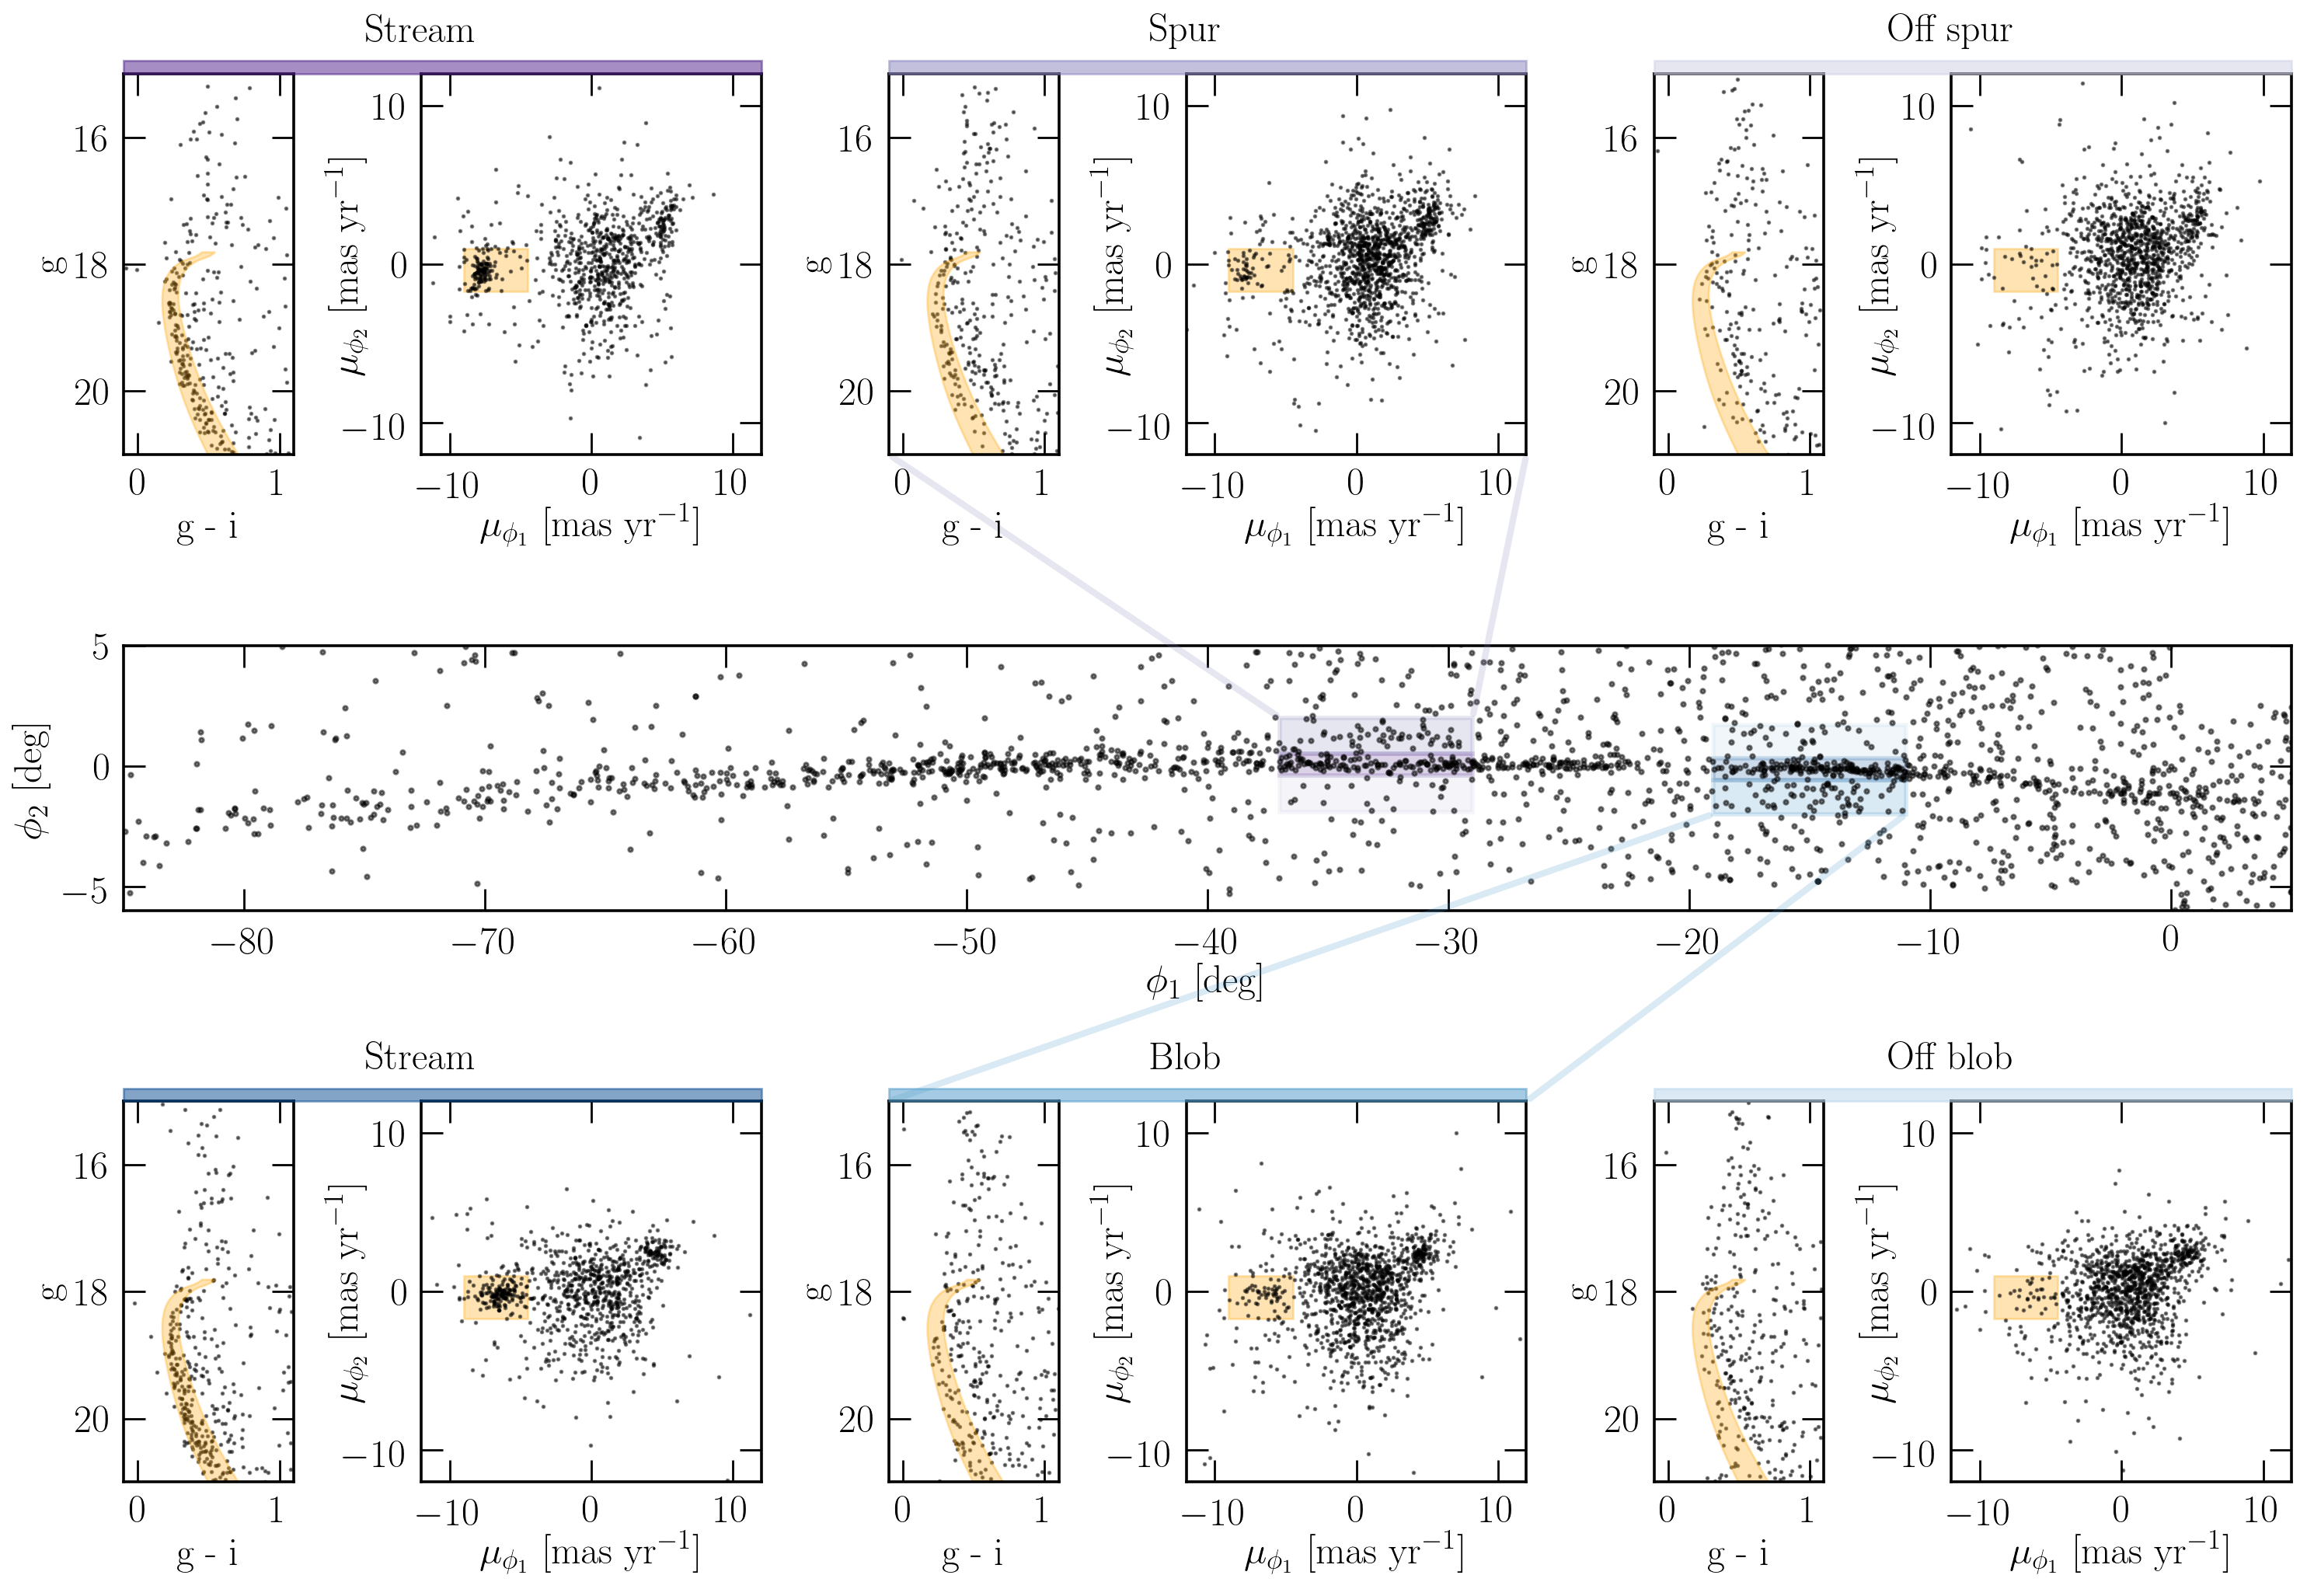

In [16]:
outer_grid = mpl.gridspec.GridSpec(3, 1, wspace=0.0, hspace=0.35)
top_row = mpl.gridspec.GridSpecFromSubplotSpec(1, 6, subplot_spec=outer_grid[0], wspace=0.5, hspace=0.05,
                                              width_ratios=[1,2,1,2,1,2])
middle_row = mpl.gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer_grid[1], wspace=0.35, hspace=0.05)
bottom_row = mpl.gridspec.GridSpecFromSubplotSpec(1, 6, subplot_spec=outer_grid[2], wspace=0.5, hspace=0.05,
                                                 width_ratios=[1,2,1,2,1,2])

fig = plt.figure(figsize=(18,12))
ax = plt.Subplot(fig, middle_row[0])
ax_main = fig.add_subplot(ax)

plt.plot(gd1_c.phi1[pm_mask & cmd_mask].wrap_at(wangle), gd1_c.phi2[pm_mask & cmd_mask],
         'ko', ms=2, alpha=0.5, rasterized=True)
plt.gca().set_aspect('equal')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')
plt.xlim(-85,5)
plt.ylim(-6,5)

rows = [top_row, bottom_row]
positions = [[1,2,3], [4,5,6]]
cmaps = [mpl.cm.Purples_r, mpl.cm.Blues_r]
ci = [0.1, 0.4, 0.7]

axes = []

for er, row in enumerate(rows):
    for e, i in enumerate(positions[er]):
        plt.sca(ax_main)
        rect_xy_ = [phi1_min[i].to(u.deg).value, phi2_min[i].to(u.deg).value]
        rect_w_ = phi1_max[i].to(u.deg).value - phi1_min[i].to(u.deg).value
        rect_h_ = phi2_max[i].to(u.deg).value - phi2_min[i].to(u.deg).value
        rect_c_ = cmaps[er](ci[e])
        
        pr = mpl.patches.Rectangle(rect_xy_, rect_w_, rect_h_, ec=rect_c_, lw=2, color=rect_c_, alpha=0.2)
        plt.gca().add_artist(pr)
        
        ax = plt.Subplot(fig, row[2*e])
        ax_1 = fig.add_subplot(ax)
        pos1 = ax_1.get_position()
        
        plt.plot(g.g[pos_masks[i] & pm_generous_mask] - g.i[pos_masks[i] & pm_generous_mask], 
                 g.g[pos_masks[i] & pm_generous_mask], 'ko', ms=1, alpha=0.5)

        pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2)
        plt.gca().add_artist(pm)

        plt.xlim(-0.1,1.1)
        plt.ylim(21, 15)
        plt.xlabel('g - i')
        plt.ylabel('g')

        ax = plt.Subplot(fig, row[2*e+1])
        ax_2 = fig.add_subplot(ax)
        pos2 = ax_2.get_position()

        plt.plot(gd1_c.pm_phi1_cosphi2[pos_masks[i] & cmd_mask].to(u.mas/u.yr), 
                 gd1_c.pm_phi2[pos_masks[i] & cmd_mask].to(u.mas/u.yr),  'ko', ms=1, alpha=0.5)

        pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
        plt.gca().add_artist(pr)
        
        x1 = pos1.x0
        y1 = pos1.y1
        w = pos2.x1 - pos1.x0
        fig.patches.extend([plt.Rectangle((x1,y1), w, 0.007,
                                  fill=True, color=rect_c_, alpha=0.5, zorder=1000,
                                  transform=fig.transFigure, figure=fig)])

        plt.xlim(-12,12)
        plt.ylim(-12,12)
        plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
        plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]', labelpad=-15)
        plt.title(titles[i], fontsize='medium', position=(-0., 1.05))
        
        if e==1:
            if er==0:
                xy_text_1 = [rect_xy_[0], rect_xy_[1] + rect_h_]
                xy_text_2 = [rect_xy_[0] + rect_w_, rect_xy_[1] + rect_h_]
                xy_coord_1 = [0,0]
                xy_coord_2 = [1,0]
            else:
                xy_text_1 = [rect_xy_[0], rect_xy_[1]]
                xy_text_2 = [rect_xy_[0] + rect_w_, rect_xy_[1]]
                xy_coord_1 = [0,1]
                xy_coord_2 = [1,1]
                
            ax_main.annotate('',xy=xy_coord_1, xytext=xy_text_1, xycoords=ax_1.transAxes, 
                             textcoords=ax_main.transData,
                            arrowprops=dict(color=rect_c_, arrowstyle='-', alpha=0.2, lw=3))
            ax_main.annotate('',xy=xy_coord_2, xytext=xy_text_2, xycoords=ax_2.transAxes, 
                             textcoords=ax_main.transData,
                            arrowprops=dict(color=rect_c_, arrowstyle='-', alpha=0.2, lw=3))

plt.savefig('../paper/features.pdf')

### Proper motion distributions

In [17]:
def mad_std(x):
    """Median absolute deviation"""
    return 1.5 * np.median(np.abs(np.median(x)-x))

In [18]:
print('median')
for i in [1,2,3,4,5,6]:
    sel = cmd_mask & pm_mask & pos_masks[i]
    m_phi1 = np.median(gd1_c.pm_phi1_cosphi2[sel]).to(u.mas/u.yr)
    m_phi2 = np.median(gd1_c.pm_phi2[sel]).to(u.mas/u.yr)
    print('{} {:.2f} {:.2f}'.format(titles[i], m_phi1, m_phi2))

median
Stream -7.67 mas / yr -0.41 mas / yr
Spur -7.72 mas / yr -0.38 mas / yr
Off spur -6.05 mas / yr 0.08 mas / yr
Stream -6.37 mas / yr -0.17 mas / yr
Blob -6.05 mas / yr -0.13 mas / yr
Off blob -6.20 mas / yr -0.29 mas / yr


In [19]:
print('mad')
for i in [1,2,3,4,5,6]:
    sel = cmd_mask & pm_mask & pos_masks[i]
    m_phi1 = mad_std(gd1_c.pm_phi1_cosphi2[sel]).to(u.mas/u.yr)
    m_phi2 = mad_std(gd1_c.pm_phi2[sel]).to(u.mas/u.yr)
    print('{} {:.2f} {:.2f}'.format(titles[i], m_phi1, m_phi2))

mad
Stream 0.48 mas / yr 0.66 mas / yr
Spur 0.70 mas / yr 0.82 mas / yr
Off spur 1.20 mas / yr 0.79 mas / yr
Stream 0.79 mas / yr 0.42 mas / yr
Blob 1.00 mas / yr 0.54 mas / yr
Off blob 0.92 mas / yr 0.59 mas / yr


## Referee's report

In [21]:
# setup bins for finding track
bin_size = 4 # deg
bin_l = np.arange(-90, (10-bin_size)+1, 2.)
bin_r = bin_l + bin_size
bin_c = 0.5 * (bin_l+bin_r)

bins_nonoverlap = np.arange(-85, (10-bin_size)+1, bin_size)
cen_phi1 = 0.5 * (bins_nonoverlap[:-1] + bins_nonoverlap[1:])

In [26]:
# median track
stream_mask = pm_mask & cmd_mask
phi2_wide_mask = stream_mask & (gd1_c.phi2 < 2.*u.deg) & (gd1_c.phi2 > -4.*u.deg)
phi2_median, be, bn = binned_statistic((gd1_c.phi1[phi2_wide_mask]).wrap_at(wangle).degree, 
                                       gd1_c.phi2[phi2_wide_mask].degree, 
                                       statistic='median', bins=bins_nonoverlap)
phi2_sum, be = np.histogram((gd1_c.phi1[phi2_wide_mask]).wrap_at(wangle).degree, 
                            bins=bins_nonoverlap)
phi2_median_err = np.abs(phi2_median) / np.sqrt(phi2_sum)

deg = 2
ptrack = np.polyfit(cen_phi1, phi2_median, deg, w=1 / np.sqrt(phi2_sum))

polytrack = np.poly1d(ptrack)
phi1_ = np.linspace(-90, 10, 100)
phi2_ = polytrack(phi1_)

In [44]:
# set up running median bins, arrays
bin_size = 3 # deg
bin_l = np.arange(-90, (10-bin_size)+1, 1.)
bin_r = bin_l + bin_size
bins_phi1 = 0.5 * (bin_l+bin_r)

Nbins = len(bin_l)
n = np.zeros(Nbins)
n_back = np.zeros(Nbins)
w = np.zeros(Nbins)*u.deg
rmed_phi2 = np.zeros(Nbins)*u.deg
rmed_p = np.zeros(Nbins)*u.mas
rmed_pmphi1 = np.zeros(Nbins)*u.mas/u.yr
rmed_pmphi2 = np.zeros(Nbins)*u.mas/u.yr
rmed_p_err = np.zeros(Nbins)*u.mas
rmed_pmphi1_err = np.zeros(Nbins)*u.mas/u.yr
rmed_pmphi2_err = np.zeros(Nbins)*u.mas/u.yr

In [45]:
# stream track properties
phi2_poly = polytrack(gd1_c.phi1[pm_mask & cmd_mask].wrap_at(180*u.deg))
off_phi2 = 2.5
delta_phi2 = 0.75
_phi1 = gd1_c.phi1[pm_mask & cmd_mask].wrap_at(180*u.deg).degree

for i, l, r in zip(range(Nbins), bin_l, bin_r):
    sel_bin = (_phi1 > l) & (_phi1 <= r)
    sel_stream = (np.abs(gd1_c.phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly) < delta_phi2)
    sel_back = ((np.abs(gd1_c.phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly - off_phi2)<delta_phi2) |
                (np.abs(gd1_c.phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly + off_phi2)<delta_phi2))
    selection = sel_bin & sel_stream
    
    n[i] = np.sum(selection)
    n_back[i] = np.sum(sel_bin & sel_back) * 0.5
    
    rmed_phi2[i] = np.nanmedian(gd1_c.phi2[pm_mask & cmd_mask][selection])
    w[i] = mad_std(gd1_c.phi2[pm_mask & cmd_mask][selection])
    
    rmed_p[i] = np.nanmedian(g.parallax[pm_mask & cmd_mask][selection])
    rmed_p_err[i] = mad_std(g.parallax[pm_mask & cmd_mask][selection])
    
    rmed_pmphi1[i] = np.nanmedian(gd1_c_noreflex.pm_phi1_cosphi2[pm_mask & cmd_mask][selection])
    rmed_pmphi1_err[i] = mad_std(gd1_c.pm_phi1_cosphi2[pm_mask & cmd_mask][selection])
    
    rmed_pmphi2[i] = np.nanmedian(gd1_c_noreflex.pm_phi2[pm_mask & cmd_mask][selection])
    rmed_pmphi2_err[i] = mad_std(gd1_c_noreflex.pm_phi2[pm_mask & cmd_mask][selection])
    
density = (n-n_back)/(2*delta_phi2*bin_size)

/home/ana/install/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/ana/install/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ana/install/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home/ana/install/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide


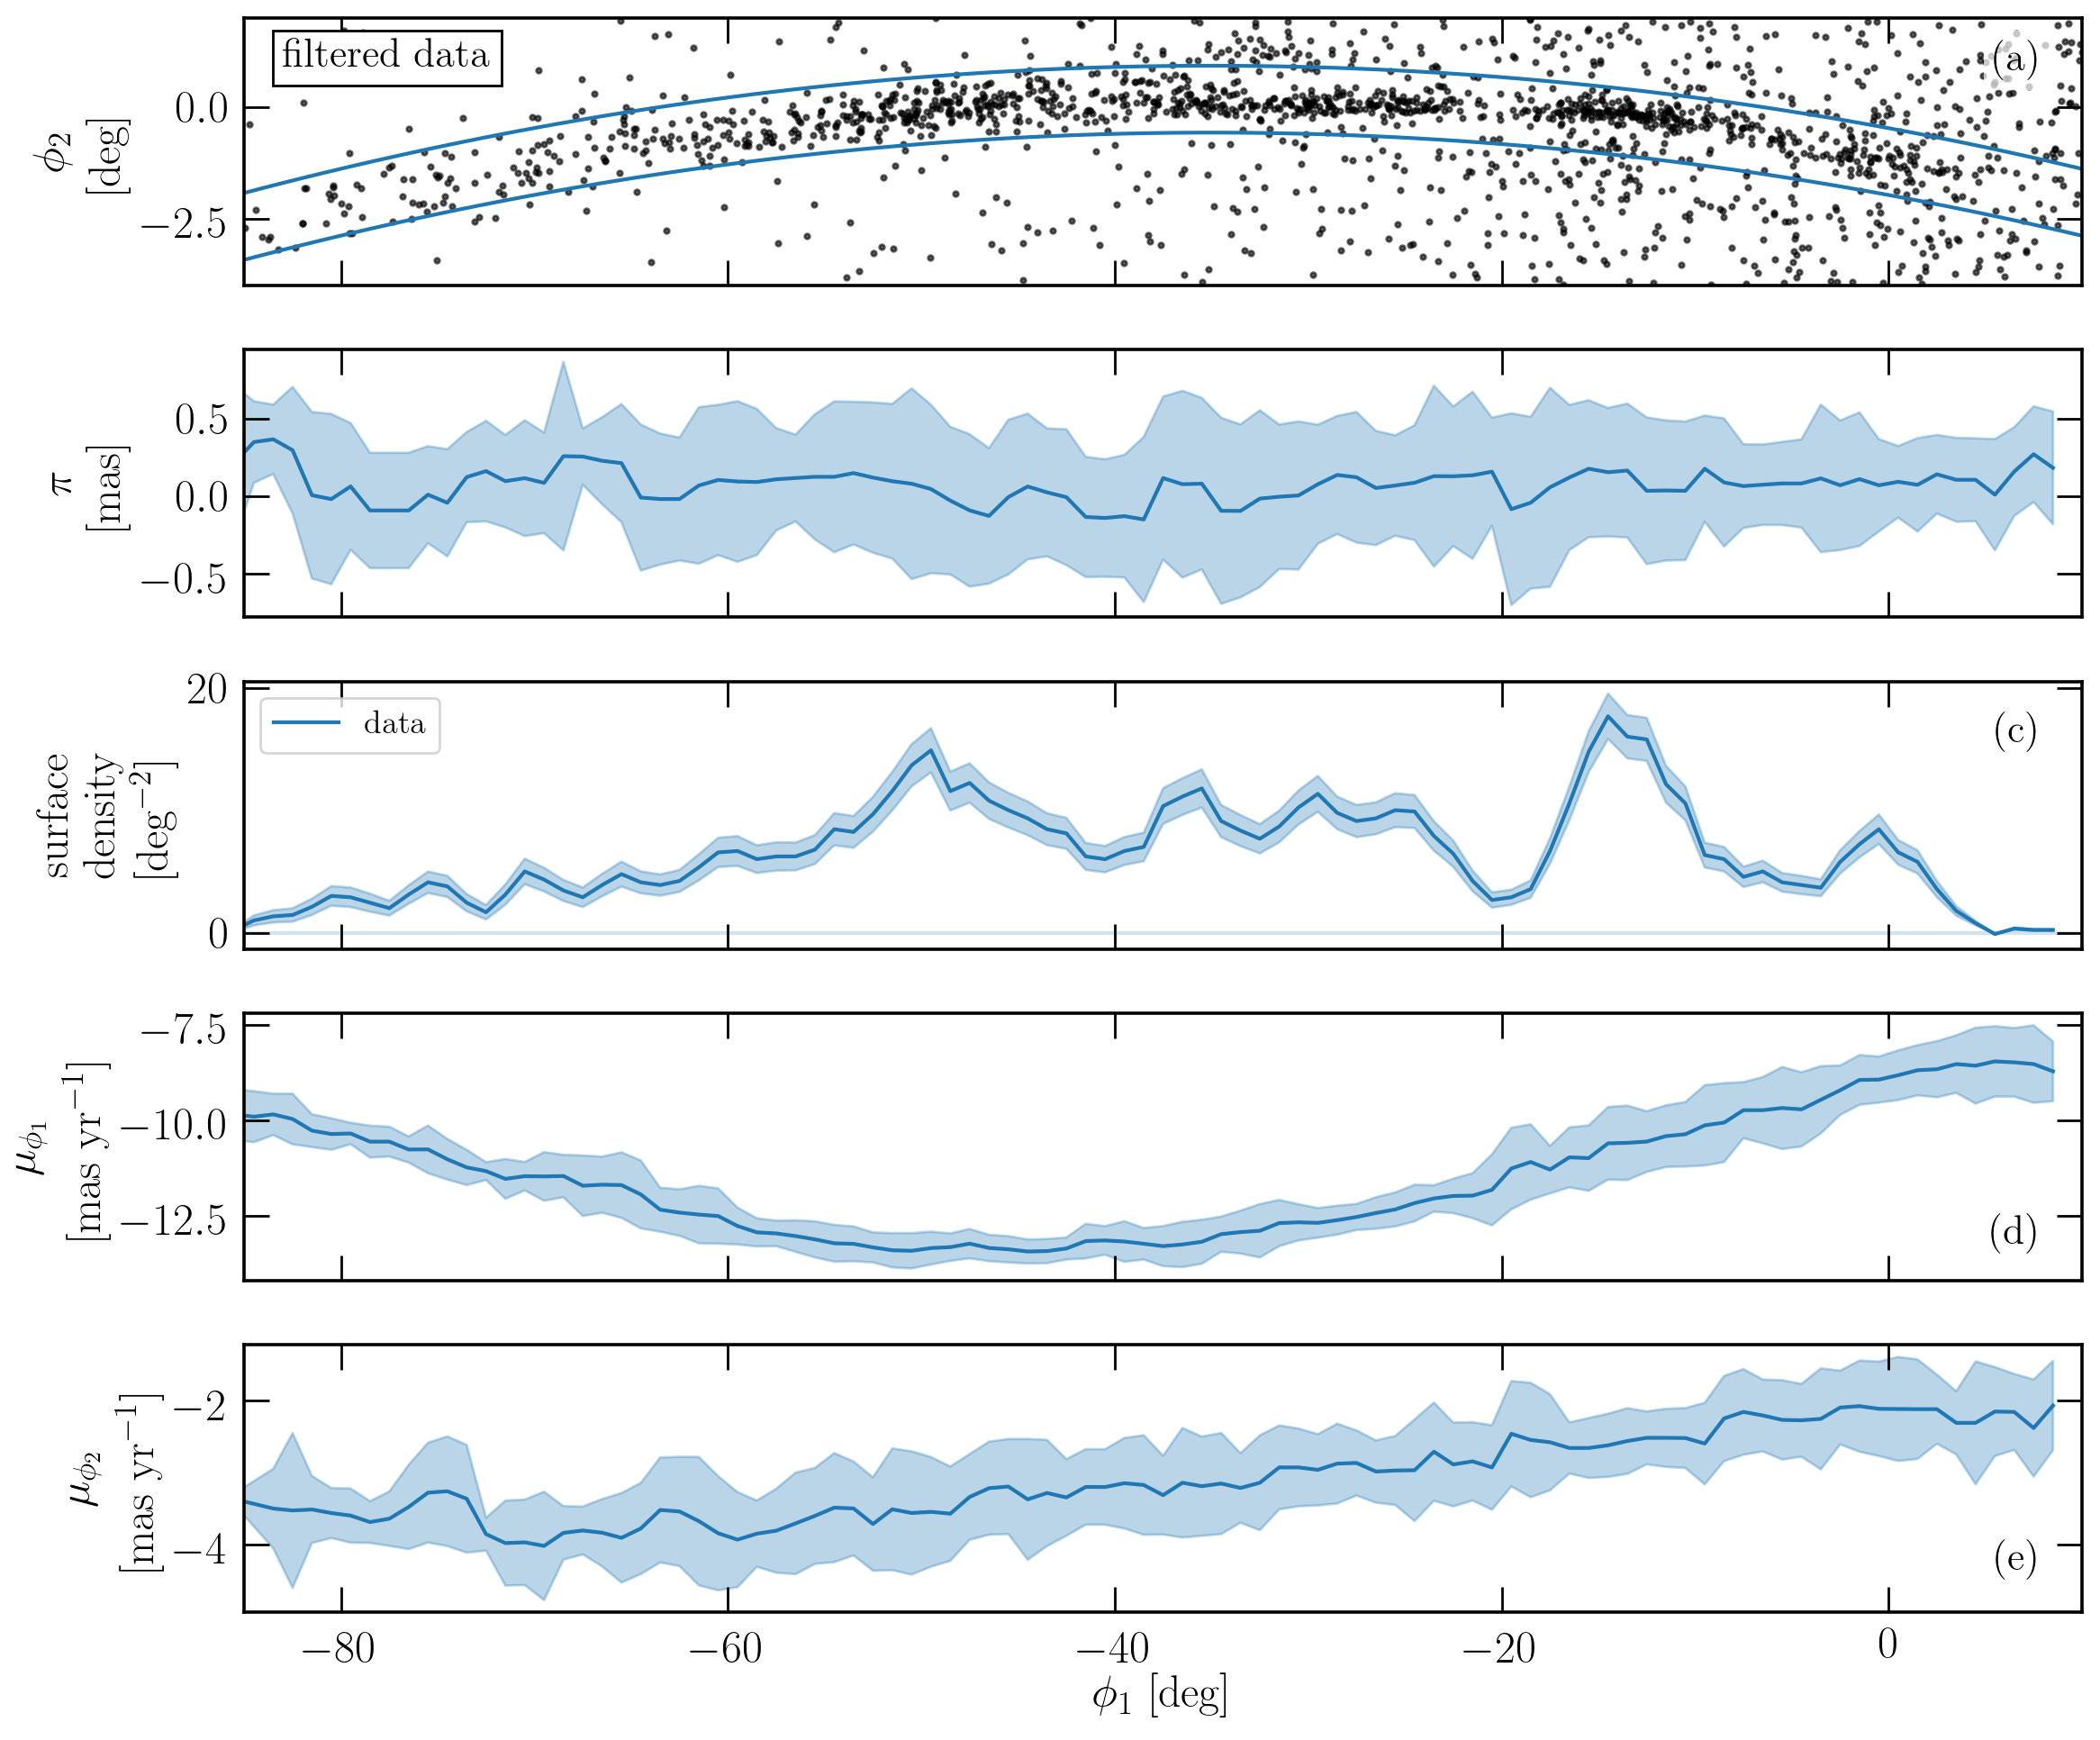

In [46]:
fig, axes = plt.subplots(5, 1, figsize=(12,10), sharex=True)

ax = axes[0]
ax.plot(gd1_c.phi1[phi2_wide_mask].wrap_at(wangle), 
        gd1_c.phi2[phi2_wide_mask], 
        'ko', ms=2, alpha=0.6, rasterized=True)

ax.plot(phi1_, phi2_+delta_phi2, '-', color='tab:blue')
ax.plot(phi1_, phi2_-delta_phi2, '-', color='tab:blue')
ax.text(-83, 1.5, 'filtered data', ha='left', va='top', 
        bbox=dict(facecolor='w', alpha=1), fontsize=16)
ax.set_ylabel('$\phi_2$\n[deg]')
ax.set_ylim(-4, 2)

ax.text(8, 1.5, '(a)', ha='right', va='top', 
        bbox=dict(facecolor='w', alpha=0.7, ec='none'), fontsize=16)

# parallax track:
ax = axes[1]
ax.plot(bins_phi1, rmed_p, '-')
ax.fill_between(bins_phi1, rmed_p-rmed_p_err, rmed_p+rmed_p_err, 
                color='tab:blue', alpha=0.3)

# ax.plot(bins_phi1, model_rmed_phi2, '--', color='tab:orange', zorder=-10, lw=2)

ax.set_ylabel('$\pi$\n[mas]')

# model stream
# ax = axes[1]
# ax.plot(stream_gd1.phi1.wrap_at(wangle), 
#         stream_gd1.phi2, 
#         marker='o', linestyle='none', ms=1., color='k', 
#         alpha=0.6, rasterized=True)

# ax.plot(phi1_, phi2_+delta_phi2, '-', color='tab:blue')
# ax.plot(phi1_, phi2_-delta_phi2, '-', color='tab:blue')
# ax.text(-83, 1.5, 'toy model', ha='left', va='top', 
#         bbox=dict(facecolor='w', alpha=1), fontsize=16)

# ax.text(8, 1.5, '(b)', ha='right', va='top', 
#         bbox=dict(facecolor='w', alpha=1), fontsize=16)

# ax.set_ylabel('$\phi_2$\n[deg]')
# ax.set_ylim(-4, 2)

ax = axes[2]
ax.plot(bins_phi1, density, '-', label='data')
ax.fill_between(bins_phi1, density*(1-1/np.sqrt(n)), density*(1+1/np.sqrt(n)), 
                color='tab:blue', alpha=0.3)
ax.axhline(0, zorder=-10, alpha=0.2)

# ax.plot(bins_phi1, model_density, '--', 
#         color='tab:orange', zorder=-10, lw=2, label='model')
ax.legend(loc='upper left', fontsize=13)

ax.set_ylabel('surface\ndensity\n[deg$^{-2}$]')

ax.text(8, 18, '(c)', ha='right', va='top', 
        bbox=dict(facecolor='w', alpha=0.3, ec='none'), fontsize=16)

ax = axes[3]
ax.plot(bins_phi1, rmed_pmphi1, '-')
ax.fill_between(bins_phi1, rmed_pmphi1-rmed_pmphi1_err, rmed_pmphi1+rmed_pmphi1_err, 
                color='tab:blue', alpha=0.3)

# ax.plot(bins_phi1, model_rmed_pmphi1, '--', 
#         color='tab:orange', zorder=-10, lw=2)

ax.set_ylabel('$\mu_{\phi_1}$\n[mas yr$^{-1}$]')

ax.text(8, -13.5, '(d)', ha='right', va='bottom', 
        bbox=dict(facecolor='w', alpha=0.3, ec='none'), fontsize=16)

ax = axes[4]
ax.plot(bins_phi1, rmed_pmphi2, '-')
ax.fill_between(bins_phi1, rmed_pmphi2-rmed_pmphi2_err, rmed_pmphi2+rmed_pmphi2_err, 
                color='tab:blue', alpha=0.3)

# ax.plot(bins_phi1, model_rmed_pmphi2, '--', color='tab:orange', zorder=-10, lw=2)

ax.set_xlabel('$\phi_1$ [deg]')
ax.set_ylabel('$\mu_{\phi_2}$\n[mas yr$^{-1}$]')

ax.text(8, -4.5, '(e)', ha='right', va='bottom', 
        bbox=dict(facecolor='w', alpha=0.3, ec='none'), fontsize=16)

axes[0].set_xlim(-85, 10)

fig.tight_layout()